In [1]:
#Import librerie
import os
from pathlib import Path
import numpy as np
from PIL import Image
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models.segmentation import fcn_resnet50

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import functional as TF
import torch
import torch.nn.functional as F

In [2]:
#Configurazioni
base_path = "/kaggle/input/coco-2017-dataset/coco2017"
train_img_dir = os.path.join(base_path, "train2017")
train_ann_file = os.path.join(base_path, "annotations/instances_train2017.json")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Hyperparameters
IMG_SIZE = (1024, 1024)
BATCH_SIZE = 2
NUM_WORKERS = 4
LR = 4.4e-4
NUM_EPOCHS = 10
NUM_IMG = 5000
CHECKPOINT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [3]:
##############################################################
#    LOSS FUNCTIONS RICHIESTE DAL PROGETTO (G4)  
#    CrossEntropy, Dice, Jaccard(IoU), Focal 
#   + combinazioni 
##############################################################

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, logits, targets):
        num_classes = logits.shape[1]
        probs = F.softmax(logits, dim=1) 
        targets_onehot = F.one_hot(targets, num_classes).permute(0,3,1,2).float()
        dims = (0,2,3)
        intersection = torch.sum(probs * targets_onehot, dims)
        union = torch.sum(probs + targets_onehot, dims)
        dice = (2*intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, logits, targets):
        num_classes = logits.shape[1]
        probs = F.softmax(logits, dim=1)
        targets_onehot = F.one_hot(targets, num_classes).permute(0,3,1,2).float()
        dims = (0,2,3)
        intersection = torch.sum(probs * targets_onehot, dims)
        union = torch.sum(probs + targets_onehot - probs * targets_onehot, dims)
        iou = (intersection + self.smooth) / (union + self.smooth)
        return 1 - iou.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss(reduction="none")

    def forward(self, logits, targets):
        ce = self.ce(logits, targets)
        pt = torch.exp(-ce)
        focal = self.alpha * (1-pt)**self.gamma * ce
        return focal.mean()


ce_loss = nn.CrossEntropyLoss() #CrossEntropyLoss
dice_loss = DiceLoss()         #DiceLoss
iou_loss = IoULoss()          #Jaccard/IoU Loss
focal_loss = FocalLoss(gamma=2.0, alpha=0.25)  #FocalLoss

#Combinazioni Loss

#CrossEntropy+Dice Loss
def loss_ce_dice(logits, targets):      
    return ce_loss(logits, targets) + dice_loss(logits, targets)

#CrossEntropy+IoU
def loss_ce_iou(logits, targets):
    return ce_loss(logits, targets) + iou_loss(logits, targets)

#Focal+Dice
def loss_focal_dice(logits, targets):
    return focal_loss(logits, targets) + dice_loss(logits, targets)

In [4]:
#Scelta Loss
def compute_loss(logits, targets):

    if LOSS_MODE == "CE":
        return ce_loss(logits, targets)

    elif LOSS_MODE == "DICE":
        return dice_loss(logits, targets)

    elif LOSS_MODE == "IOU":
        return iou_loss(logits, targets)

    elif LOSS_MODE == "FOCAL":
        return focal_loss(logits, targets)

    elif LOSS_MODE == "CE+DICE":
        return loss_ce_dice(logits, targets)

    elif LOSS_MODE == "CE+IOU":
        return loss_ce_iou(logits, targets)

    elif LOSS_MODE == "FOCAL+DICE":
        return loss_focal_dice(logits, targets)

    else:
        raise ValueError(f"Loss non riconosciuta: {LOSS_MODE}")


LOSS_MODE = "CE"
LOSS_NAMES = {
    "CE": "CrossEntropy Loss",
    "DICE": "Dice Loss",
    "IOU": "IoU / Jaccard Loss",
    "FOCAL": "Focal Loss",
    "CE+DICE": "CrossEntropy + Dice Loss",
    "CE+IOU": "CrossEntropy + IoU Loss",
    "FOCAL+DICE": "Focal + Dice Loss"
}
print(f"Loss selezionata: {LOSS_NAMES.get(LOSS_MODE, 'Unknown Loss')}")

Loss selezionata: CrossEntropy Loss


In [5]:
coco = COCO(train_ann_file)
cat_ids = sorted(coco.getCatIds()) 
cat2label = {cat_id: idx+1 for idx, cat_id in enumerate(cat_ids)}

NUM_CLASSES = len(cat_ids) + 1 
print("NUM_CLASSES (including background):", NUM_CLASSES)


loading annotations into memory...
Done (t=19.98s)
creating index...
index created!
NUM_CLASSES (including background): 81


In [6]:
#DatasetCustom
class COCOSegmentationDataset(Dataset):
    def __init__(self, img_dir, coco, cat2label, target_size=(1024,1024)):
        self.img_dir = img_dir
        self.coco = coco
        self.ids = coco.getImgIds()
        self.cat2label = cat2label
        self.target_size = target_size

    def _build_mask(self, anns, h, w):
        mask = np.zeros((h, w), dtype=np.uint8)
        anns = sorted(anns, key=lambda a: a["area"], reverse=True)
        for ann in anns:
            m = self.coco.annToMask(ann)
            label = self.cat2label[ann["category_id"]]
            mask[m > 0] = label
        return mask

    def _resize_(self, img, target_size, resample):
        tw, th = target_size
        h, w = img.size
        scale = min(tw / w, th / h)
        nw, nh = int(w * scale), int(h * scale)
        img = img.resize((nw, nh), resample)
        canvas = Image.new(img.mode, (tw, th), 0)
        canvas.paste(img, ((tw - nw)//2, (th - nh)//2))
        return canvas

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, info["file_name"])

        img = Image.open(img_path).convert("RGB")
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = Image.fromarray(self._build_mask(anns, info["height"], info["width"]))

        # Resize 
        img = self._resize_(img, self.target_size, Image.BILINEAR)
        mask = self._resize_(mask, self.target_size, Image.NEAREST)

        img = TF.to_tensor(img)
        mask = torch.tensor(np.array(mask), dtype=torch.long)

        return img, mask

    def __len__(self):
        return len(self.ids)


In [7]:
full_dataset = COCOSegmentationDataset(train_img_dir, coco, cat2label, target_size=IMG_SIZE)
small_subset = torch.utils.data.Subset(full_dataset, list(range(min(NUM_IMG, len(full_dataset)))))
num_samples = len(small_subset)
num_train = int(num_samples*0.8)
num_val = num_samples - num_train
train_set, val_set = torch.utils.data.random_split(small_subset, [num_train, num_val])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Train:", len(train_set))
print("Val:", len(val_set))

Train: 4000
Val: 1000


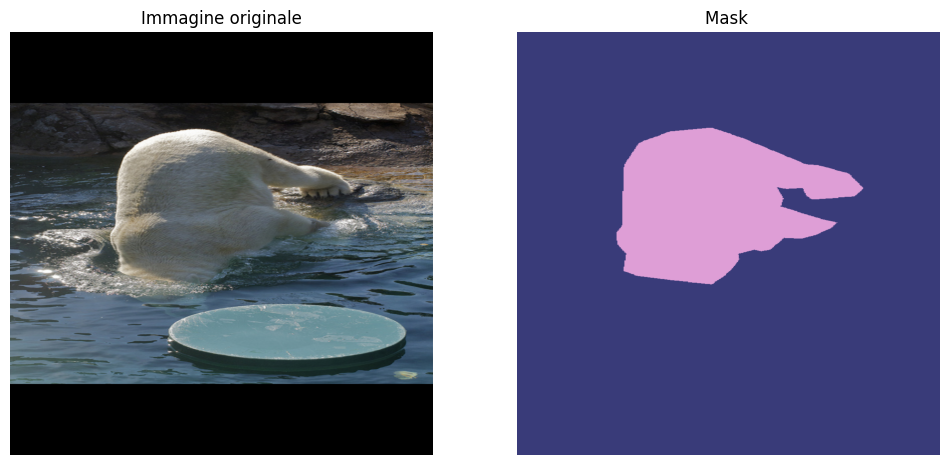

In [8]:
def show_gt_sample(dataset, idx):
    img, mask = dataset[idx]
    img_np = img.permute(1, 2, 0).numpy()

    num_classes = mask.max().item() + 1 

    # Colormap 
    cmap = plt.get_cmap("tab20b", num_classes) 
    mask_color = cmap(np.arange(num_classes) / (num_classes - 1))[:, :3] 
    mask_color = (mask_color * 255).astype(np.uint8)
    mask_color[1] = np.array([255, 0, 0], dtype=np.uint8) #Color-mask rossa per persone 
    mask_rgb = mask_color[mask.numpy()]

    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title("Immagine originale")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask_rgb)
    plt.title("Mask ")
    plt.axis("off")

    plt.show()


show_gt_sample(small_subset, random.randint(0, len(small_subset)-1))

In [9]:
# Model: FCN-ResNet50 from scratch
model = fcn_resnet50(weights=None, num_classes=NUM_CLASSES).to(DEVICE)

# Otimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


In [10]:
# 10 learning rate  tra 1e-3 e 1e-5

#lr_values = np.logspace(-2, -5, 10)
#print("Learning rates:", lr_values)
#results_train_loss = []
#results_val_loss = []

#for lr in lr_values:
    #print(f"  Addestramento completo con LR = {lr:.6e}")
    #model = fcn_resnet50(weights=None, num_classes=NUM_CLASSES).to(DEVICE)
    #optimizer = optim.Adam(model.parameters(), lr=lr)

    #best_train_loss = None
    #best_val_loss = None

    #for epoch in range(1, NUM_EPOCHS + 1):
        # TRAIN 

        #model.train()
        #running_train_loss = 0.0
        #pbar = tqdm(train_loader, desc=f"LR={lr:.1e} | Epoch {epoch}/{NUM_EPOCHS}")
        #for i, (imgs, masks) in enumerate(pbar, 1):
            #imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

            #optimizer.zero_grad()
            #outputs = model(imgs)["out"]
            #loss = criterion(outputs, masks)
            #loss.backward()
            #optimizer.step()

            #running_train_loss += loss.item()
            #avg_train_loss = running_train_loss / i
            #pbar.set_postfix(train_loss=f"{avg_train_loss:.4f}")

        #VALIDATION 

        #model.eval()
        #running_val_loss = 0.0
        #with torch.no_grad():
            #for imgs, masks in val_loader:
                #imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
                #outputs = model(imgs)["out"]
                #loss = criterion(outputs, masks)
                #running_val_loss += loss.item()

        #avg_val_loss = running_val_loss / len(val_loader)

        #print(f"Epoch {epoch}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}")

        # Salvataggio miglior loss lungo le epoche
        #if best_train_loss is None or avg_train_loss < best_train_loss:
         #   best_train_loss = avg_train_loss
        #if best_val_loss is None or avg_val_loss < best_val_loss:
         #   best_val_loss = avg_val_loss

    
    #results_train_loss.append(best_train_loss)
    #results_val_loss.append(best_val_loss)

    #print(f"--> LR={lr:.1e} | best_train_loss={best_train_loss:.4f}, best_val_loss={best_val_loss:.4f}")

    # libero memoria GPU prima di passare al prossimo LR
    #del model, optimizer
    #torch.cuda.empty_cache()

In [11]:
#plt.figure(figsize=(8,5))

#plt.semilogx(lr_values, results_val_loss, marker="o", label="Best Validation Loss")
#plt.semilogx(lr_values, results_train_loss, marker="x", linestyle="--", label="Best Train Loss")

#plt.xlabel("Learning Rate")
#plt.ylabel("Loss")
#plt.title("Sweep Learning Rate [1e-2, 1e-5]")
#plt.grid(True, which="both")
#plt.legend()
#plt.show()

In [12]:
# Eseguire questa cella solo in caso di interruzione anomala del training
# Tenta di caricare il checkpoint se esiste

ckpt_path = os.path.join(CHECKPOINT_DIR, "checkpoint.pth")
if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    best_val_loss = checkpoint["best_val_loss"]
    start_epoch = checkpoint["epoch"] + 1
    print(f"Ripreso training dall'epoca {start_epoch}")
else:
    print("Nessun checkpoint trovato, parto da zero.")
    start_epoch = 0

Nessun checkpoint trovato, parto da zero.


In [13]:
import os, csv, time
from pathlib import Path
import torch

CHECKPOINT_DIR = Path(CHECKPOINT_DIR)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

HISTORY_CSV = CHECKPOINT_DIR / "history.csv"
CHECKPOINT_PATH = CHECKPOINT_DIR / "checkpoint.pth"

# -------------------------
# Utility: init/append CSV
# -------------------------
CSV_HEADER = [
    "epoch", "train_loss", "val_loss",
    "lr", "elapsed_sec", "timestamp"
]

def ensure_history_csv(path: Path):
    if not path.exists():
        with open(path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(CSV_HEADER)

def append_history_row(path: Path, row: dict):
    with open(path, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([row.get(k, "") for k in CSV_HEADER])

def get_lr(optimizer):
    # prende il primo gruppo (tipico)
    return optimizer.param_groups[0].get("lr", None)

# -------------------------
# (Opzionale) Ripresa: se c'è checkpoint, carica tutto
# -------------------------
start_epoch = 0
best_val_loss = float("inf")
train_losses, val_losses = [], []

if CHECKPOINT_PATH.exists():
    ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    scheduler.load_state_dict(ckpt["scheduler_state"])
    best_val_loss = ckpt.get("best_val_loss", float("inf"))

    # Ricostruzione history anche se CSV manca
    train_losses = ckpt.get("train_losses", [])
    val_losses   = ckpt.get("val_losses", [])

    # Riparte dall'epoch successiva a quella salvata
    start_epoch = ckpt["epoch"] + 1
    print(f"Ripreso da epoch {start_epoch} | best_val_loss={best_val_loss:.6f}")

ensure_history_csv(HISTORY_CSV)

# -------------------------
# Training loop con salvataggio history + checkpoint
# -------------------------
for epoch in range(start_epoch, NUM_EPOCHS):
    t0 = time.time()

    # ---- TRAIN ----
    model.train()
    running_train = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for i, (imgs, masks) in enumerate(pbar, 1):
        imgs  = imgs.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(imgs)["out"]
        loss = compute_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_train += loss.item()
        pbar.set_postfix(train_loss=running_train / i)

    avg_train = running_train / len(train_loader)
    train_losses.append(avg_train)

    # ---- VAL ----
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs  = imgs.to(DEVICE, non_blocking=True)
            masks = masks.to(DEVICE, non_blocking=True)

            outputs = model(imgs)["out"]
            loss = compute_loss(outputs, masks)
            running_val += loss.item()

    avg_val = running_val / len(val_loader)
    val_losses.append(avg_val)

    # ---- SCHEDULER ----
    # Se usi ReduceLROnPlateau -> scheduler.step(avg_val)
    try:
        scheduler.step(avg_val)
    except TypeError:
        scheduler.step()

    elapsed = time.time() - t0
    lr = get_lr(optimizer)

    print(f"Epoch {epoch+1} | Train: {avg_train:.4f} | Val: {avg_val:.4f} | LR: {lr}")

    # ---- APPEND CSV HISTORY (sempre, ogni epoch) ----
    append_history_row(HISTORY_CSV, {
        "epoch": epoch,
        "train_loss": avg_train,
        "val_loss": avg_val,
        "lr": lr,
        "elapsed_sec": elapsed,
        "timestamp": int(time.time())
    })

    # ---- CHECKPOINT COMPLETO ----
    # salva SEMPRE uno "last", e inoltre aggiorna "best" se migliora
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best_val_loss": best_val_loss,
        "train_losses": train_losses,
        "val_losses": val_losses,
    }
    torch.save(checkpoint, CHECKPOINT_DIR / "last_checkpoint.pth")

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        checkpoint["best_val_loss"] = best_val_loss
        torch.save(checkpoint, CHECKPOINT_PATH)
        print("Checkpoint BEST aggiornato.")

print(f"History CSV salvata in: {HISTORY_CSV}")
print(f"Checkpoint BEST: {CHECKPOINT_PATH}")
print(f"Checkpoint LAST: {CHECKPOINT_DIR / 'last_checkpoint.pth'}")


Epoch 1/10: 100%|██████████| 2000/2000 [34:40<00:00,  1.04s/it, train_loss=1.14]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1 | Train: 1.1370 | Val: 1.0817 | LR: 0.0004274192937921906
Checkpoint BEST aggiornato.


Epoch 2/10: 100%|██████████| 2000/2000 [34:41<00:00,  1.04s/it, train_loss=1.02]


Epoch 2 | Train: 1.0230 | Val: 1.0421 | LR: 0.00042831510950715727
Checkpoint BEST aggiornato.


Epoch 3/10: 100%|██████████| 2000/2000 [34:41<00:00,  1.04s/it, train_loss=0.967]


Epoch 3 | Train: 0.9672 | Val: 0.9435 | LR: 0.0004304057938745136
Checkpoint BEST aggiornato.


Epoch 4/10: 100%|██████████| 2000/2000 [34:41<00:00,  1.04s/it, train_loss=0.919]


Epoch 4 | Train: 0.9190 | Val: 0.9351 | LR: 0.0004305748121808417
Checkpoint BEST aggiornato.


Epoch 5/10: 100%|██████████| 2000/2000 [34:41<00:00,  1.04s/it, train_loss=0.88]


Epoch 5 | Train: 0.8802 | Val: 0.8959 | LR: 0.0004313442992982857
Checkpoint BEST aggiornato.


Epoch 6/10: 100%|██████████| 2000/2000 [34:41<00:00,  1.04s/it, train_loss=0.839]


Epoch 6 | Train: 0.8387 | Val: 0.8424 | LR: 0.00043234120965784034
Checkpoint BEST aggiornato.


Epoch 7/10: 100%|██████████| 2000/2000 [34:41<00:00,  1.04s/it, train_loss=0.805]


Epoch 7 | Train: 0.8052 | Val: 0.8506 | LR: 0.00043219117361907654


Epoch 8/10: 100%|██████████| 2000/2000 [34:41<00:00,  1.04s/it, train_loss=0.778]


Epoch 8 | Train: 0.7782 | Val: 0.8522 | LR: 0.00043216312374511545


Epoch 9/10: 100%|██████████| 2000/2000 [34:41<00:00,  1.04s/it, train_loss=0.751]


Epoch 9 | Train: 0.7508 | Val: 0.9141 | LR: 0.0004309902180916252


Epoch 10/10: 100%|██████████| 2000/2000 [34:42<00:00,  1.04s/it, train_loss=0.727]


Epoch 10 | Train: 0.7266 | Val: 0.8078 | LR: 0.0004329544170925831
Checkpoint BEST aggiornato.
History CSV salvata in: /kaggle/working/checkpoints/history.csv
Checkpoint BEST: /kaggle/working/checkpoints/checkpoint.pth
Checkpoint LAST: /kaggle/working/checkpoints/last_checkpoint.pth


In [14]:
IGNORE_INDEX = None

# =========================
# Helpers
# =========================
def loss_name_for_filename(loss_mode, loss_names):
    if loss_mode not in loss_names:
        tag = str(loss_mode).lower()
    else:
        tag = loss_names[loss_mode].lower()
    tag = tag.replace(" ", "_").replace("+", "_plus_").replace("/", "_")
    # pulizia extra
    while "__" in tag:
        tag = tag.replace("__", "_")
    return tag.strip("_")

def update_confusion_matrix(cm, preds, targets, num_classes, ignore_index=None):
    preds = preds.view(-1)
    targets = targets.view(-1)

    if ignore_index is not None:
        m = (targets != ignore_index)
        preds = preds[m]
        targets = targets[m]

    k = (targets >= 0) & (targets < num_classes)
    targets = targets[k]
    preds   = preds[k]

    idx = targets * num_classes + preds
    bc = torch.bincount(idx, minlength=num_classes * num_classes)
    cm += bc.reshape(num_classes, num_classes)
    return cm

def miou_from_cm(cm):
    cm = cm.float()
    tp = torch.diag(cm)
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    denom = tp + fp + fn
    iou = torch.where(denom > 0, tp / denom, torch.full_like(denom, float("nan")))
    miou = torch.nanmean(iou)
    return miou.item(), iou.detach().cpu().numpy()

# =========================
# File mIoU (nome include LOSS_MODE + LOSS_NAMES)
# =========================
CHECKPOINT_DIR = Path(CHECKPOINT_DIR)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

loss_tag = loss_name_for_filename(LOSS_MODE, LOSS_NAMES)
MIOU_FILE = CHECKPOINT_DIR / f"miou_{LOSS_MODE}_{loss_tag}.csv"

if not MIOU_FILE.exists():
    with open(MIOU_FILE, "w", newline="") as f:
        f.write("epoch,miou\n")

# =========================
# CALCOLO + SALVATAGGIO mIoU (chiamalo a fine epoch)
# =========================
model.eval()
cm = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.int64, device=DEVICE)

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs  = imgs.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)

        logits = model(imgs)["out"]       # (B,C,H,W)
        preds  = logits.argmax(dim=1)     # (B,H,W)

        cm = update_confusion_matrix(cm, preds, masks, NUM_CLASSES, ignore_index=IGNORE_INDEX)

miou, _ = miou_from_cm(cm)

# 'epoch' deve esistere nel tuo loop; se stai testando fuori, definiscilo tu
with open(MIOU_FILE, "a", newline="") as f:
    f.write(f"{epoch},{miou:.6f}\n")

print(f"mIoU={miou:.4f} | salvata in: {MIOU_FILE}")

mIoU=0.0404 | salvata in: /kaggle/working/checkpoints/miou_CE_crossentropy_loss.csv


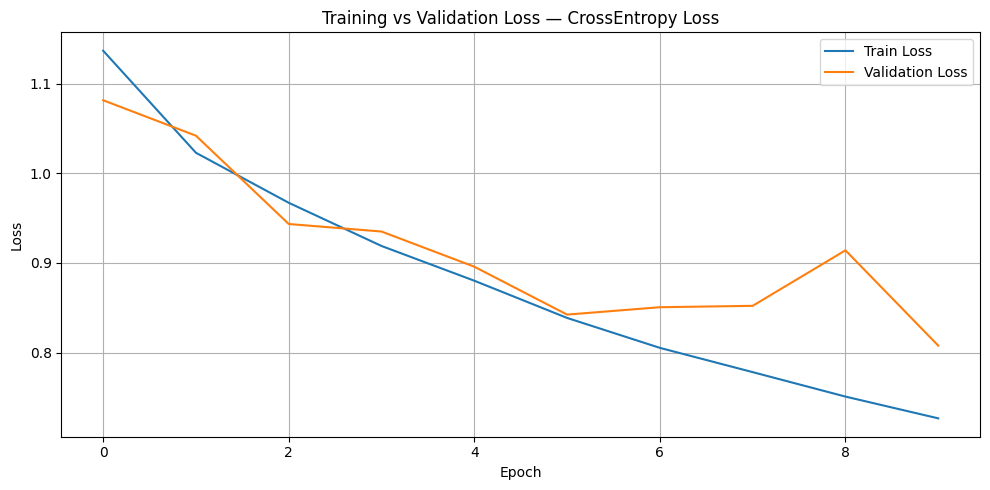

Grafico loss salvato in: /kaggle/working/checkpoints/loss_curve_CE_crossentropy_loss.png


In [15]:
import matplotlib.pyplot as plt
loss_tag = loss_name_for_filename(LOSS_MODE, LOSS_NAMES)

# =========================
# Percorso di salvataggio
# =========================
OUT_DIR = Path(CHECKPOINT_DIR)
OUT_DIR.mkdir(parents=True, exist_ok=True)

PLOT_PATH = OUT_DIR / f"loss_curve_{LOSS_MODE}_{loss_tag}.png"

# Recupero nome loss leggibile
loss_title = LOSS_NAMES.get(LOSS_MODE, LOSS_MODE)

# Grafico
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training vs Validation Loss — {loss_title}")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig(PLOT_PATH, dpi=150)
plt.close()

print(f"Grafico loss salvato in: {PLOT_PATH}")

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path

def loss_name_for_filename(loss_mode, loss_names):
    if loss_mode not in loss_names:
        tag = str(loss_mode).lower()
    else:
        tag = loss_names[loss_mode].lower()
    tag = tag.replace(" ", "_").replace("+", "_plus_").replace("/", "_")
    while "__" in tag:
        tag = tag.replace("__", "_")
    return tag.strip("_")

def visualize_fixed_samples_and_save(
    dataset,
    model,
    indices,
    num_classes,
    loss_mode,
    loss_names,
    device,
    save_dir,
    alpha=0.5,
    ignore_index=None,
    auto_fix=True,
):
    n_ds = len(dataset)

    # ---- valida/fissa indici ----
    valid = [i for i in indices if 0 <= i < n_ds]
    if auto_fix and len(valid) < len(indices):
        need = len(indices) - len(valid)
        fallback = np.linspace(0, n_ds - 1, num=max(need, 1)+2, dtype=int)[1:-1].tolist()
        for f in fallback:
            if f not in valid and len(valid) < len(indices):
                valid.append(int(f))
    for f in range(n_ds):
        if len(valid) >= len(indices):
            break
        if f not in valid:
            valid.append(f)
    indices = valid[:len(indices)]

    # ---- nome loss ----
    loss_title = loss_names.get(loss_mode, loss_mode)
    loss_tag = loss_name_for_filename(loss_mode, loss_names)

    # ---- colormap ----
    cmap_base = plt.get_cmap("tab20")
    colors = (cmap_base(np.arange(num_classes) / max(num_classes - 1, 1))[:, :3] * 255).astype(np.uint8)

    def mask_to_rgb(mask):
        rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for c in range(num_classes):
            rgb[mask == c] = colors[c]
        return rgb

    model.eval()
    n = len(indices)
    plt.figure(figsize=(5 * n, 8))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, gt_mask = dataset[idx]

            inp = img.unsqueeze(0).to(device)
            pred = model(inp)["out"].argmax(1).squeeze(0).cpu().numpy()

            img_np = img.permute(1, 2, 0).cpu().numpy()
            gt_np  = gt_mask.cpu().numpy()

            if ignore_index is not None:
                pred = pred.copy()
                gt_np = gt_np.copy()
                pred[gt_np == ignore_index] = 0
                gt_np[gt_np == ignore_index] = 0

            pred_rgb = mask_to_rgb(pred)
            gt_rgb   = mask_to_rgb(gt_np)

            # Riga 1: predizione
            ax = plt.subplot(2, n, i + 1)
            ax.imshow(img_np)
            ax.imshow(pred_rgb, alpha=alpha)
            ax.set_title(f"Sample {idx} – Prediction")
            ax.axis("off")

            # Riga 2: ground truth
            ax = plt.subplot(2, n, i + 1 + n)
            ax.imshow(img_np)
            ax.imshow(gt_rgb, alpha=alpha)
            ax.set_title(f"Sample {idx} – Ground Truth")
            ax.axis("off")

    plt.suptitle(f"Overlay Prediction vs Ground Truth — {loss_title}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    # ---- SALVATAGGIO ----
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    out_path = save_dir / f"immagini_test_{loss_mode}_{loss_tag}.png"
    plt.savefig(out_path, dpi=150)
    plt.close()

    print(f"Figura salvata in: {out_path}")

# =========================
# USO
# =========================
FIXED_INDICES = [12, 45, 128]

visualize_fixed_samples_and_save(
    dataset=small_subset,
    model=model,
    indices=FIXED_INDICES,
    num_classes=NUM_CLASSES,
    loss_mode=LOSS_MODE,
    loss_names=LOSS_NAMES,
    device=DEVICE,
    save_dir=CHECKPOINT_DIR,   # stessa cartella dei checkpoint
    alpha=0.5,
    ignore_index=None,
    auto_fix=True
)


Figura salvata in: /kaggle/working/checkpoints/immagini_test_CE_crossentropy_loss.png


In [17]:
import shutil
from pathlib import Path

SRC_DIR = Path("/kaggle/working/checkpoints")
ZIP_PATH = Path("/kaggle/working/checkpoints.zip")

# Rimuove eventuale zip precedente
if ZIP_PATH.exists():
    ZIP_PATH.unlink()

# Crea lo zip
shutil.make_archive(
    base_name=str(ZIP_PATH).replace(".zip", ""),
    format="zip",
    root_dir=str(SRC_DIR)
)

print(f"Archivio creato: {ZIP_PATH}")


Archivio creato: /kaggle/working/checkpoints.zip
